# NLP PROJECT 

Topic :- Abstract Segementation of Medical research papers.

Made By :- Prajwal Pande(BT19ECE013) & Umang Doble Pawar(BT19ECE038)

In [1]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# tensorflow imports
import tensorflow as tf

# sklearn imports
import json
from sklearn.metrics import precision_recall_fscore_support

# nltk imports
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [2]:
!wget https://raw.githubusercontent.com/Prajwal007-supernova-sonic/NLP-PROJECT/main/PyTorch_helper.py
from Pytorch_Helper import LabelEncoder, Tokenizer, Trainer

!wget https://raw.githubusercontent.com/Prajwal007-supernova-sonic/NLP-PROJECT/main/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, pred_and_plot, unzip_data, walk_through_dir

--2022-11-08 19:05:17--  https://raw.githubusercontent.com/vishalrk1/pytorch/main/Pytorch_Helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11016 (11K) [text/plain]
Saving to: ‘Pytorch_Helper.py’

Pytorch_Helper.py   100%[===================>]  10.76K  --.-KB/s    in 0s      

2022-11-08 19:05:18 (66.0 MB/s) - ‘Pytorch_Helper.py’ saved [11016/11016]

--2022-11-08 19:05:18--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

data_dir = '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign'

filename = [data_dir + filename for filename in os.listdir(data_dir)]
filename

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md
dev.txt  test.txt  train.txt


['/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_signdev.txt',
 '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_signtrain.zip',
 '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_signtest.txt']

In [4]:
# function to read abstracts from text files
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

In [5]:
train_lines = get_lines('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt')
train_lines[:5]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n']

In [6]:
# downloading stopwords
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")
print(f"stopwords: {STOPWORDS[:5]}")

porter = PorterStemmer()

stopwords: ['i', 'me', 'my', 'myself', 'we']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
def preprocess_text_with_line_number(filename):
  """
  returns a list of dictionary of lines data
  
  """

  input_lines = get_lines(filename)
  abstract_lines = ''
  abstract_samples = []

  for line in input_lines:
    if line.startswith('###'):
      abstract_id = line
      abstract_lines = ''
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()
    
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split('\t')
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1].lower()
        line_data['line_number'] = abstract_line_number
        line_data['total_lines'] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)
    
    else:
       abstract_lines += line

  return abstract_samples

In [8]:
# getting data from file and preocess it
train_samples = preprocess_text_with_line_number('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt')
val_samples = preprocess_text_with_line_number('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt')
test_samples = preprocess_text_with_line_number('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt')

In [9]:
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [10]:
train_samples = train_samples[:60004]
val_samples = val_samples[:10006]
test_samples = test_samples[:5002]

len(train_samples), len(val_samples), len(test_samples)

(60004, 10006, 5002)

In [11]:
# convertind dictionary lists into pandas dataframe
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [12]:
train_df['target'].value_counts()

METHODS        19821
RESULTS        19222
CONCLUSIONS     9109
BACKGROUND      7150
OBJECTIVE       4702
Name: target, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


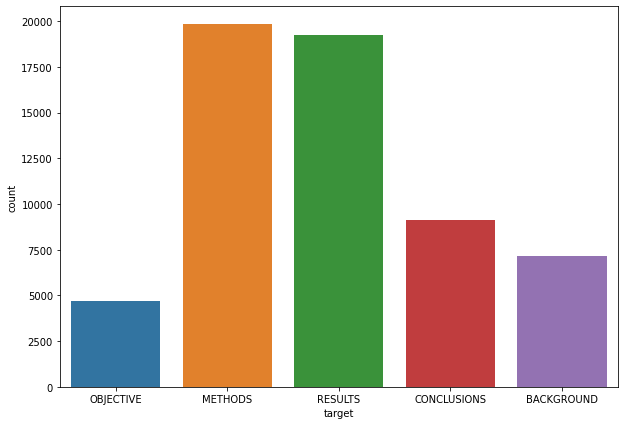

In [13]:
plt.figure(figsize=(10,7))
sns.countplot('target',data=train_df);

In [14]:
# downloading stopwords
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")
print(f"stopwords: {STOPWORDS[:5]}")

porter = PorterStemmer()

stopwords: ['i', 'me', 'my', 'myself', 'we']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
def preprocess(text, stopwords=STOPWORDS):
    """Conditional preprocessing on our text unique to our task."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r"\b(" + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub("", text)

    # Remove words in paranthesis
    text = re.sub(r"\([^)]*\)", "", text)

    # Spacing and filters
    text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)
    text = re.sub("[^A-Za-z0-9]+", " ", text) # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()

    return text

In [16]:
# Apply to dataframe
preprocessed_df = train_df.copy()
preprocessed_df.text = preprocessed_df.text.apply(preprocess)

print(f"{train_df.text.values[0]}\n\n{preprocessed_df.text.values[0]}")

to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .

investigate efficacy weeks daily low dose oral prednisolone improving pain mobility systemic low grade inflammation short term whether effect would sustained weeks older adults moderate severe knee osteoarthritis


In [17]:
preprocessed_val_df = val_df.copy()
preprocessed_val_df.text = val_df.text.apply(preprocess)

In [18]:
preprocessed_test_df = test_df.copy()
preprocessed_test_df.text = preprocessed_test_df.text.apply(preprocess)

In [19]:
train_sentences = preprocessed_df['text'].tolist()
val_sentences = preprocessed_val_df['text'].tolist()
test_sentences = preprocessed_test_df['text'].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(60004, 10006, 5002)

In [20]:
label_encoder = LabelEncoder()
label_encoder.fit(preprocessed_df.target.to_list())

NUM_CLASSES = len(label_encoder)
print(NUM_CLASSES)

label_encoder.class_to_index

5


{'BACKGROUND': 0, 'CONCLUSIONS': 1, 'METHODS': 2, 'OBJECTIVE': 3, 'RESULTS': 4}

In [21]:
class_names = label_encoder.class_to_index.keys()
print(class_names)

dict_keys(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'])


In [22]:
# Converting all targets into numbers
y_train = label_encoder.encode(preprocessed_df.target.to_list())
y_val = label_encoder.encode(preprocessed_val_df.target.to_list())
y_test = label_encoder.encode(test_df.target.to_list())

In [23]:
y_train[:5]

array([3, 2, 2, 2, 2])

In [24]:
tokenizer = Tokenizer(char_level=False, num_tokens=80000)

In [25]:
# fiting tokenizer on train sentences
tokenizer.fit_on_texts(texts=train_sentences)
VOCAB_SIZE = len(tokenizer)

print(VOCAB_SIZE)

26637


In [26]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

# nltk.download("stopwords")
# STOPWORDS = stopwords.words("english")
# porter = PorterStemmer()

def download_stopwords():
  nltk.download("stopwords")
  STOPWORDS = stopwords.words("english")
  porter = PorterStemmer()
  return STOPWORDS, porter

def preprocess(text, stopwords=STOPWORDS):
    """Conditional preprocessing on our text unique to our task."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r"\b(" + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub("", text)

    # Remove words in paranthesis
    text = re.sub(r"\([^)]*\)", "", text)

    # Spacing and filters
    text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)
    text = re.sub("[^A-Za-z0-9]+", " ", text) # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()

    return text

from spacy.lang.en import English

# -------------------------------------------------------------------------------------------------------

def gather_last_relevant_hidden(hiddens, seq_lens):
    seq_lens = seq_lens.long().detach().cpu().numpy() - 1
    out = []
    for batch_index, column_index in enumerate(seq_lens):
        out.append(hiddens[batch_index, column_index])
    return torch.stack(out)

# ----------------------------------------------------------------------------------------------------------

def pad_sequences(sequences, max_seq_len=0):
    """Pad sequences to max length in sequence."""
    max_seq_len = max(max_seq_len, max(len(sequence) for sequence in sequences))
    padded_sequences = np.zeros((len(sequences), max_seq_len))
    for i, sequence in enumerate(sequences):
        padded_sequences[i][:len(sequence)] = sequence
    return padded_sequences

# -------------------------------------------------------------------------------------------------------

def spacy_function(abstract):
    
  # setup English sentence parser
  nlp = English()

  # create sentence splitting pipeline object
  sentencizer = nlp.create_pipe("sentencizer")

  # add sentence splitting pipeline object to sentence parser
  nlp.add_pipe('sentencizer')
    
  # create "doc" of parsed sequences, change index for a different abstract
  doc = nlp(abstract) 

  # return detected sentences from doc in string type (not spaCy token type)
  abstract_lines = [str(sent) for sent in list(doc.sents)]
    
  return abstract_lines

# ---------------------------------------------------------------------------------------------------------------------------

def split_character(text):
  return ' '.join(list(text))
    
# ---------------------------------------------------------------------------------------------------------------------------

def eval_step(model, dataloader, device):
    """Validation or test step."""
    # Set model to eval mode
    model.eval()
    loss = 0.0
    acc = 0.0
    y_trues, y_probs = [], []

    # Iterate over val batches
    with torch.inference_mode():
      for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):

        # Step
        batch = [item.to(device) for item in batch]  # Set device
        x_in, seq_lens = batch[:-1], batch[-1]
        z = model(x_in[0], seq_lens)  # Forward pass

        # Store outputs
        y_prob = F.softmax(z).cpu().numpy()
        y_probs.extend(y_prob)

    return np.vstack(y_probs)

# ---------------------------------------------------------------------------------------------------------------------------

# --------------------------------------------------------------------------------------------------------------------------

class BiLSTMModel(nn.Module):
  def __init__(self, embedding_dim, vocab_size, hidden_dim, n_layers, linear_output, 
               num_classes, padding_idx=0):
    super(BiLSTMModel, self).__init__()

    # Initalizing Embedding
    self.embeddings = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

    # LSTM layers
    self.bilstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, batch_first=True, bidirectional=True)

    # FC layers
    self.fc1 = nn.Linear(2*hidden_dim, linear_output)
    self.fc2 = nn.Linear(linear_output, num_classes)
    self.dropout = nn.Dropout(0.4)

  def forward(self, x_in, seq_lens):
    # x_in, seq_lens = inputs
    x_in = self.embeddings(x_in)

    # RNN outputs 
    out, b_n = self.bilstm(x_in)
    x = gather_last_relevant_hidden(hiddens=out, seq_lens=seq_lens)

    # FC layers output
    x = self.fc1(x)
    x = self.dropout(x)
    x = self.fc2(x)
    return x

# ---------------------------------------------------------------------------------------------------------------------------
class BIDataset(Dataset):
  def __init__(self, X):
    self.X = X

  def __len__(self):
    return len(self.X)

  def __str__(self):
    return f"<Dataset(N={len(self.X)})>"

  def __getitem__(self, index):
    X = self.X[index]
    return [X, len(X)]
  
  def collate_fn(self, batch):
    """Processing on a batch"""
    # Getting Input
    batch = np.array(batch)
    X = batch[:,0]
    seq_lens = batch[:, 1]

    # padding inputsaa
    X = pad_sequences(sequences=X) # max_seq_len=max_length

    # converting inputs to tensors
    X = torch.LongTensor(X.astype(np.int32))
    seq_lens = torch.LongTensor(seq_lens.astype(np.int32))
    
    return X, seq_lens

  def create_dataloader(self, batch_size, shuffle=False, drop_last=False):
    dataloader = DataLoader(dataset=self, batch_size=batch_size, collate_fn=self.collate_fn, shuffle=shuffle, drop_last=drop_last, pin_memory=True)
    return dataloader
# ---------------------------------------------------------------------------------------------------------------------------

def make_predictions(text, model_path, tokenizer, label_encoder, device):
  # getting all lines seprated from abstract
  abstract_lines = list()
  abstract_lines = spacy_function(text)  
    
  # Get total number of lines
  total_lines_in_sample = len(abstract_lines)

  # Go through each line in abstract and create a list of dictionaries containing features for each line
  sample_lines = []
  for i, line in enumerate(abstract_lines):
    sample_dict = {}
    sample_dict["text"] = str(line)
    sample_dict["line_number"] = i
    sample_dict["total_lines"] = total_lines_in_sample - 1
    sample_lines.append(sample_dict)

  # converting sample line list into pandas Dataframe
  df = pd.DataFrame(sample_lines)

  # getting stopwords 
  STOPWORDS, porter = download_stopwords()

  # applying preprocessing function to lines
  df.text = df.text.apply(lambda x: preprocess(x, STOPWORDS))

  text_input = tokenizer.texts_to_sequences(df.text.to_list())

  # creating Dataset
  dataset = BIDataset(text_input)

  # creating dataloader
  dataloader = dataset.create_dataloader(batch_size=4)
  batch = next(iter(dataloader))

  # creating model
  model =  BiLSTMModel(embedding_dim=128, vocab_size=26637, hidden_dim=128, n_layers=3, linear_output=64, num_classes=5)
  model = model.to(device)

  # loading model weight
  model.load_state_dict(torch.load(model_path))

  # setting model into evaluation mode
  model.eval()

  # getting predictions 
  y_prob = eval_step(model=model, dataloader=dataloader, device=device)
  y_pred = np.argmax(y_prob, axis=1)
  pred = label_encoder.decode(y_pred)

  return abstract_lines, pred

Few Abstract for Sample

In [28]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
    example_abstracts = json.load(f)

abstracts = pd.DataFrame(example_abstracts)
abstracts.head()

--2022-11-08 19:11:35--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2022-11-08 19:11:36 (61.9 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [30]:
import torch
from tqdm.notebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

label_encoder = LabelEncoder.load(fp='/content/drive/MyDrive/NLP PROJECT/NLP-Project-LabelEncode.json')
tokenizer = Tokenizer.load('/content/drive/MyDrive/NLP PROJECT/NLP-Project-Word-Tokenizer.json')

abstract_lines, pred = make_predictions(
    abstracts.abstract[2], 
    '/content/drive/MyDrive/NLP PROJECT/biLstm_model_1.pt', 
    tokenizer,
    label_encoder,
    device,
)

cpu


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:103: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [31]:
abstracts.abstract[1]

"Postpartum depression (PPD) is the most prevalent mood disorder associated with childbirth. No single cause of PPD has been identified, however the increased risk of nutritional deficiencies incurred through the high nutritional requirements of pregnancy may play a role in the pathology of depressive symptoms. Three nutritional interventions have drawn particular interest as possible non-invasive and cost-effective prevention and/or treatment strategies for PPD; omega-3 (n-3) long chain polyunsaturated fatty acids (LCPUFA), vitamin D and overall diet. We searched for meta-analyses of randomised controlled trials (RCT's) of nutritional interventions during the perinatal period with PPD as an outcome, and checked for any trials published subsequently to the meta-analyses. Fish oil: Eleven RCT's of prenatal fish oil supplementation RCT's show null and positive effects on PPD symptoms. Vitamin D: no relevant RCT's were identified, however seven observational studies of maternal vitamin D 

Final Output

In [32]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
    print(f"{pred[i]}: {line}")

CONCLUSIONS: Mental illness, including depression, anxiety and bipolar disorder, accounts for a significant proportion of global disability and poses a substantial social, economic and heath burden.
CONCLUSIONS: Treatment is presently dominated by pharmacotherapy, such as antidepressants, and psychotherapy, such as cognitive behavioural therapy; however, such treatments avert less than half of the disease burden, suggesting that additional strategies are needed to prevent and treat mental disorders.
CONCLUSIONS: There are now consistent mechanistic, observational and interventional data to suggest diet quality may be a modifiable risk factor for mental illness.
RESULTS: This review provides an overview of the nutritional psychiatry field.
CONCLUSIONS: It includes a discussion of the neurobiological mechanisms likely modulated by diet, the use of dietary and nutraceutical interventions in mental disorders, and recommendations for further research.
BACKGROUND: Potential biological pathwa